In [1]:
#NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import cv2
import seaborn as sb
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


In [127]:
reg_dir = pathlib.Path('/nemo/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/allen_ccf_coord')
ROI_path = pathlib.Path('/nemo/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/rois')
ROI_table = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/ROI_vol.pkl')
allen_converted_path = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/allenccf/allen_ccf_coord')
convert_to_flat_path = allen_converted_path.parents[1]
lcm_reg_dir = pathlib.PurePath('/nemo/lab/znamenskiyp/home/shared/code/MAPseq_processing/AC_MAPseq/Brain1_FIAA32.6a/LCM_registration')
reads_path = pathlib.Path("/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together")
RTtosample = pd.read_csv(allen_converted_path.parents[2]/ 'Sequencing/Processed_data/UpdatedApril/tube_to_RT.csv')
#normalised_barcode_path= pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together/barcode_matrix_normalised.pkl')
normalised_barcode_path= pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together/barcodes_with_leiden_cluster_label_with_no_source_higher_leiden.pkl')
areas = pd.read_csv(lcm_reg_dir/'3d_areas.csv')

In [3]:
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path/"flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path/"labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere='right_for_both',

    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere='flatmap_butterfly',
)

In [5]:
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path/"flatmap_butterfly.h5",

    # Specify our streamline file
    convert_to_flat_path/"surface_paths_10_v3.h5",

    # Specify that we want to project both hemispheres
    hemisphere="both",

    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere='flatmap_butterfly',
)

loading path information


100%|██████████| 1016/1016 [00:05<00:00, 169.71it/s]


In [7]:
ROI_flatmap = np.load(convert_to_flat_path/'ROI_cortical_3D.npy')

In [128]:
clustered_bc =pd.read_pickle(normalised_barcode_path)

In [129]:
#remove tubes in ROI flatmap that aren't in normalised barcode path
tubes = np.arange(1, 94, 1)
tubes_not_in = [i for i in tubes if i not in clustered_bc.columns.to_list()]

In [9]:
for x in tubes_not_in:
    ROI_flatmap[ROI_flatmap == x] = 0

In [10]:

ROI_projection_max = proj_top.project_volume(ROI_flatmap)

In [130]:
barcode_matrix = np.zeros((len(clustered_bc), max(clustered_bc.columns.to_list())+1))
for column in clustered_bc:
    barcode_matrix[:, column] = clustered_bc[column].to_numpy()

In [131]:
sub_cortical= {}
sub_cortical['IC'] = [86, 89, 90]
sub_cortical['SC'] = [68, 78, 92, 87, 69, 79, 93]
#sub_cortical['CLA'] = [20, 25, 9, 14]
sub_cortical['R_STR'] = [8, 13, 19]
sub_cortical['C_STR'] = [29]
sub_cortical['PONS'] = [72, 80, 88]
#only look at subcortical regions that have passed qc
sub_cortical_updated = {}
for i in sub_cortical:
    sub_cortical_updated[i] = []
    for val in sub_cortical[i]:
        if val in clustered_bc.columns.to_list():
            sub_cortical_updated[i].append(val)

In [136]:
cluster ='22'
cluster_df = clustered_bc[clustered_bc.index==cluster]

cluster_table = cluster_df.loc[:, (cluster_df != 0).any(axis=0)]
show_me = cluster_df.loc[:, (cluster_df != 0).any(axis=0)]
show_me

,71
leiden,
22,1.0
22,1.0
22,1.0
22,1.0
22,1.0
22,1.0
22,1.0
22,1.0
22,1.0


In [89]:
show_me.sum()

29    107.858871
37      0.141129
dtype: float64

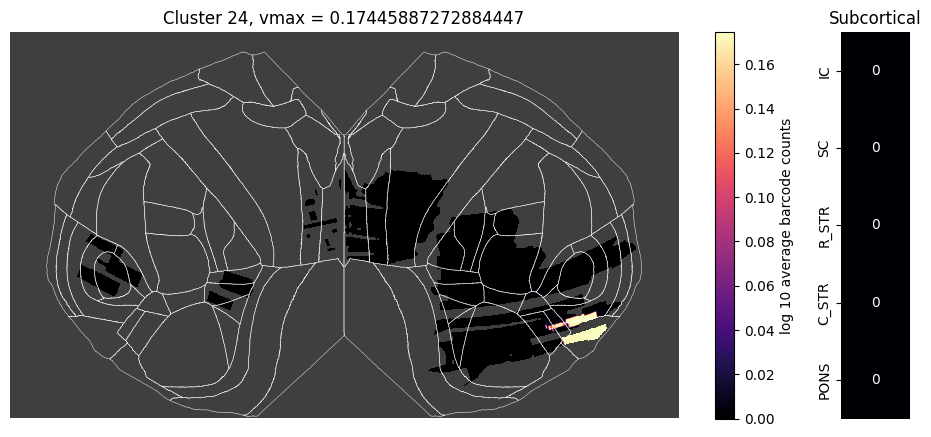

In [145]:
cluster = '24'
cluster_df = clustered_bc[clustered_bc.index==cluster]
cluster_matrix = np.zeros((len(cluster_df), max(cluster_df.columns.to_list())+1))
for column in cluster_df:
    cluster_matrix[:, column] = cluster_df[column].to_numpy()

normalized_matrix_mean = np.mean(cluster_matrix, axis=0)
normalized_matrix_mean[0] = -1
fig = plt.figure(figsize=(14, 300))
cmap = plt.cm.get_cmap("magma").copy()

#new_colours = cmap(np.linspace(0, 1, 30))
#grey = ([0.3, 0.3, 0.3, 1])
#new_colours[0, :] = grey
#new_cmap = ListedColormap(new_colours)
cmap.set_bad(color=[0.25, 0.25, 0.25, 1])       
gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.15])

ax1 = fig.add_subplot(gs[1, 0])

new_mat = np.log10(1 + normalized_matrix_mean[ROI_projection_max.astype(int)]).T
vmax_max =  np.log10(normalized_matrix_mean.max() + 1)#np.partition(normalized_matrix_mean.flatten(), -2)[-2]
new_fig = ax1.imshow(new_mat, cmap=cmap, vmax =vmax_max)
plt.title(f'Cluster {cluster}, vmax = {vmax_max}')
ax1.axis('off')
cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
cbar.set_label('log 10 average barcode counts')


for k, boundary_coords in bf_left_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)
for k, boundary_coords in bf_right_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)

# Subplot - Seaborn heatmap
sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
for col in sub_cort_heat.columns:
        sub_cort_heat.loc[0, col] = np.log10(normalized_matrix_mean[sub_cortical_updated[col]].sum()+1)
ax2 = fig.add_subplot(gs[1, 1])
sb.heatmap(sub_cort_heat.T, annot=True, cmap=cmap, cbar=False, cbar_ax=ax2, vmax=vmax_max)
ax2.set_title('Subcortical')
ax2.set(xticklabels=[])
#ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
ax2.tick_params(left=True, bottom=False)


Look at individual barcode projection patterns within cluster

In [146]:
all_areas_fractions = pd.DataFrame(index=clustered_bc.columns)
all_areas_fractions['name'] = ''
areas_to_look = areas.set_index('sample')
#drop tube 5, which has no registration information
areas_to_look = areas_to_look.drop(5, axis =0)
for i, row in areas_to_look.iterrows():
    row /= row.sum(0)
    
    if row[row.idxmax()]>0.9999:
        name= str(row.idxmax()) + ' ' + str(row[row.idxmax()].round(2))
    else:
        second_highest_row = row.drop(row.idxmax())
        name= str(row.idxmax()) + ' ' + str(row[row.idxmax()].round(2)) + ' ' + str(second_highest_row.idxmax()) + ' ' + str(row[second_highest_row.idxmax()].round(2))
    all_areas_fractions.loc[i] = name
    

In [149]:
#also calculate sum of projection density
density_barcodes = pd.DataFrame()
for col in clustered_bc.columns:
    density_barcodes[col] = clustered_bc[col]/(areas_to_look.loc[col].sum())



In [155]:
barcode_density_matrix.shape

(266, 94)

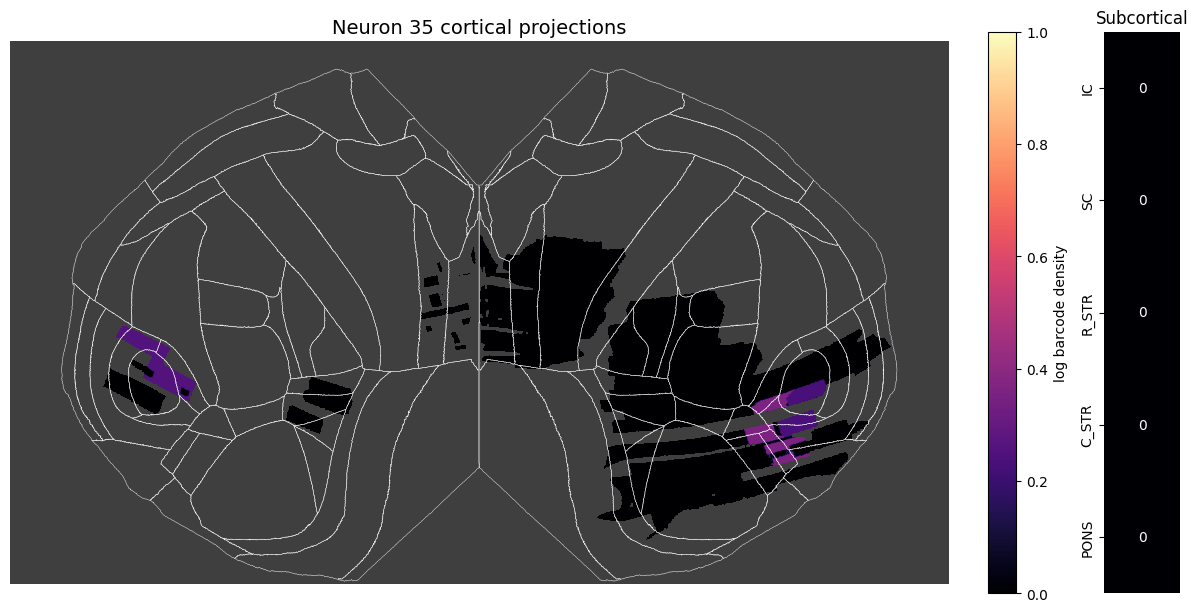

In [176]:
# Create the main figure and gridspec
cluster = '10'
cluster_df = density_barcodes[density_barcodes.index==cluster].reset_index(drop = True)
barcode_density_matrix = np.zeros((len(cluster_df), max(cluster_df.columns.to_list())+1))
for column in cluster_df:
    barcode_density_matrix[:, column] = cluster_df[column].to_numpy()
barcode_density_matrix[:, 0] = -1
barcode_index = np.random.randint(len(cluster_df))
fig = plt.figure(figsize=(12, 300))
gs = fig.add_gridspec(50, 2, width_ratios=[2, 0.15])
cmap = plt.cm.get_cmap("magma").copy()
vmax_max = barcode_density_matrix.max()
#new_colours = cmap(np.linspace(0, 1, 30))
#grey = ([0.3, 0.3, 0.3, 1])
#new_colours[0, :] = grey
#new_cmap = ListedColormap(new_colours)
cmap.set_bad(color=[0.25, 0.25, 0.25, 1])
# Iterate over barcode_index values

    # add a new subplot iteratively
    #
    # Subplot - Main plot
ax1 = fig.add_subplot(gs[1, 0])
new_mat = np.log(1 + barcode_density_matrix[barcode_index, ROI_projection_max.astype(int)]).T
new_fig = ax1.imshow(new_mat, cmap=cmap, vmax =vmax_max)
ax1.axis('off')
cbar = fig.colorbar(new_fig, ax=ax1, fraction=0.03, pad=0.04)
cbar.set_label('log barcode density')

ax1.set_title(f'Neuron {barcode_index} cortical projections', fontdict={'fontsize': 14})
for k, boundary_coords in bf_left_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)
for k, boundary_coords in bf_right_boundaries.items():
    ax1.plot(*boundary_coords.T, c="white", lw=0.3)

# Subplot - Seaborn heatmap
sub_cort_heat = pd.DataFrame(columns=sub_cortical.keys(), dtype="float")
for col in sub_cort_heat.columns:
        sub_cort_heat.loc[0, col] = np.log(barcode_density_matrix[barcode_index,sub_cortical_updated[col]].sum()+1)
ax2 = fig.add_subplot(gs[1, 1])
sb.heatmap(sub_cort_heat.T, annot=True, cmap=cmap, cbar=False, cbar_ax=ax2, vmax=vmax_max)
ax2.set_title('Subcortical')
ax2.set(xticklabels=[])
#ax2.set_yticklabels(labels=sub_cortical.keys(), rotation=0)
ax2.tick_params(left=True, bottom=False)
    
plt.tight_layout()
plt.show()

#plt.savefig(convert_to_flat_path/f'example_projections/random_{iteration}.pdf')